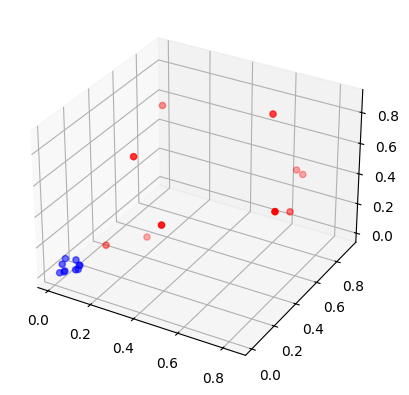

-11.933853841002874
-14.452889018359027
-11.230615418353016
-11.674926316699274
-11.849831391017053
-12.00681184883799
-12.150070089785892
-12.282225592087487
-12.403145867258445
-12.514188361571675
-12.617192018102784
-12.712247608890166
-12.80012149967489
-12.881636375289615
-12.95777042684513
-13.028575020014848
-13.09439075539183
-13.155647963413086
-13.212801987700209
-13.266172273064338


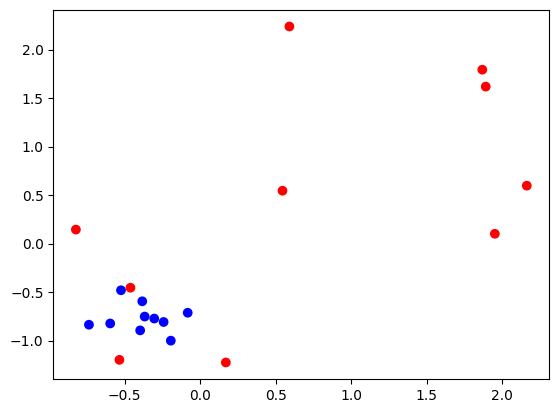

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
PERPLEXITY=5
g_kernel=1
EPOCHS=2000
LR=200
MOMENTUM=0.99

def getKey(item):
    return item[1]

#compute the distance between the neighboors of x1 and return a list of the k neghboors
#where k is the complexity
def k_neighbours(x,x1_index,p_or_q='p'):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:PERPLEXITY]

#compute the similarity pij between two xi,xj in the original space
#divide the distance between xi,xj by the sum of the distances of the k_neightbours where k is the complexity
def compute_pij(x,x1_index,x2_index):
    x1=x[x1_index]
    x2=x[x2_index]
    # num=(1+np.linalg.norm(x1-x2)**2)**(-1)/(2*g_kernel**2))
    num=np.exp(-np.linalg.norm(x1-x2)**2)/(2*g_kernel**2)
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p')
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom


#compute the table p of the xij in the original space
def compute_p(x):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j)
                pji=compute_pij(x,j,i)
                table[i,j]=(pij+pji)/(2*x.shape[0])
                # table[i,j]=pij
    return table

#compute the similarity qij between two yi,yj in the new space
#divide the distance between yi,yj by the sum of the distances of the k_neightbours where k is the complexity
def compute_qij(y,y1_index,y2_index):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q'):
        denom+=i[1]
    return num/denom

#compute the table q of the yij in the new space
def compute_q(y):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j)
                table[i,j]=qij
    return table

#compute the erros between the 2 distributions using the KL-divergence
def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total

#apply gradient descent to lower the KL-divergence
#added momentum increase the speed
def gradient_descent(p,q,y):
    history=np.zeros((p.shape[0],2,y.shape[1]))
    for iter in range(EPOCHS):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*LR*sum_value+MOMENTUM*(history[i,1]-history[i,0])
            history[i,0]=history[i,1]
            history[i,1]=y[i]
        if iter%100==0:
            q=compute_q(y)
            print(kl_divergence(p,q)) 
    y-=np.mean(y)
    y/=np.std(y)
    return y


def main():
    #I choose a dataset with two well separated part
    x=np.random.rand(10,3)
    x=np.tile(x,(2,1))
    x[:10]*=0.1
    color=['blue']*10+['red']*10

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2],color=color)
    plt.show()

    table_p=compute_p(x)

    #Probably not the right way to initialize the new space y
    y=x.dot(np.random.rand(x.shape[1],2))
    y-=np.mean(y)
    y/=np.std(y)
    table_q=compute_q(y)
    y=gradient_descent(table_p,table_q,y)

    plt.scatter(y[:,0],y[:,1],color=color)
    plt.show()

main()

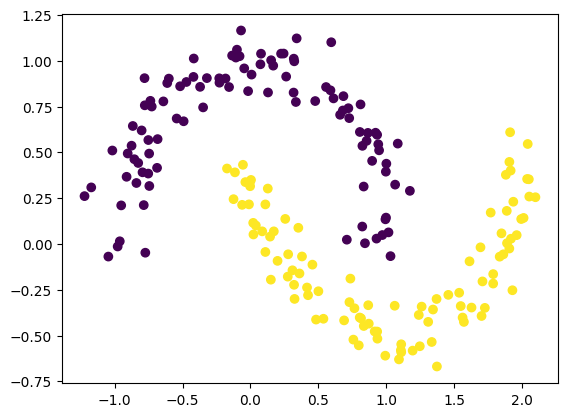

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [18]:
from sklearn.manifold import TSNE
import numpy as np

# Données X et y sont déjà définies

# Initialisation des listes pour stocker les divergences de Kullback-Leibler
kl_divergences_random = []
kl_divergences_pca = []

# Itération sur 10 répétitions pour chaque méthode d'initialisation
for _ in range(10):
    # Avec méthode d'initialisation random
    tsne_random = TSNE(n_components=2, perplexity=30, init='random')
    embedding_random = tsne_random.fit_transform(X)
    kl_divergences_random.append(tsne_random.kl_divergence_)

    # Avec méthode d'initialisation pca
    tsne_pca = TSNE(n_components=2, perplexity=30, init='pca')
    embedding_pca = tsne_pca.fit_transform(X)
    kl_divergences_pca.append(tsne_pca.kl_divergence_)

# Calcul de la moyenne et de l'écart-type pour chaque méthode d'initialisation
mean_kl_random = np.mean(kl_divergences_random)
std_kl_random = np.std(kl_divergences_random)
mean_kl_pca = np.mean(kl_divergences_pca)
std_kl_pca = np.std(kl_divergences_pca)

# Affichage des résultats
print("Méthode d'initialisation random :")
print("Moyenne de la divergence de Kullback-Leibler :", mean_kl_random)
print("Écart-type de la divergence de Kullback-Leibler :", std_kl_random)

print("\nMéthode d'initialisation pca :")
print("Moyenne de la divergence de Kullback-Leibler :", mean_kl_pca)
print("Écart-type de la divergence de Kullback-Leibler :", std_kl_pca)


Méthode d'initialisation random :
Moyenne de la divergence de Kullback-Leibler : 0.14814044833183287
Écart-type de la divergence de Kullback-Leibler : 0.0006052147142199355

Méthode d'initialisation pca :
Moyenne de la divergence de Kullback-Leibler : 0.14903636276721954
Écart-type de la divergence de Kullback-Leibler : 0.0
